In [204]:
import pandas as pd
import matplotlib.pyplot as plt

In [205]:
########## Balance mix strategy

In [206]:
### BM Low-cap Scenario

In [279]:
l_BM_variables = pd.read_csv(r'../../results/lowcap-BM-optimized-variables.csv', low_memory=False)

In [280]:
l_BM_coefficients = pd.read_csv(r'../../results/lowcap-BM-coefficients.csv', low_memory=False)

In [281]:
busiest_day= pd.read_csv(r'../../results/busiest-day-trips-info.csv', low_memory=False)

In [282]:
data = {'Variable': ['x_CDB[low-cap,0,528277]'], 'Value': [1]}
l_BM_variables = pd.DataFrame(l_BM_variables)

# Extract attributes
l_BM_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = l_BM_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')

# Drop rows with nan values
l_BM_variables = l_BM_variables.dropna()

# Convert Year to numeric
l_BM_variables['Year'] = l_BM_variables['Year'].astype(int)

In [283]:
l_BM_coefficients = pd.DataFrame(l_BM_coefficients)

# Extract values using regex
l_BM_coefficients[['Scenario', 'Year', 'Trip']] = l_BM_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")

# Drop rows with NaN values (in case some rows don't match the pattern)
l_BM_coefficients = l_BM_coefficients.dropna()

# Convert 'Year' column to integer
l_BM_coefficients['Year'] = l_BM_coefficients['Year'].astype(int)

In [284]:
l_BM_variables['Trip'] = l_BM_variables['Trip'].astype(str)
busiest_day['TripKey'] = busiest_day['TripKey'].astype(str)

# Merge the dataframes on matching values
merged_df = l_BM_variables.merge(l_BM_coefficients[['Scenario', 'Year', 'Trip', 'Coefficient']],
                                on=['Scenario', 'Year', 'Trip'],
                                how='left')


# Update h_BM_variables
l_BM_variables = merged_df

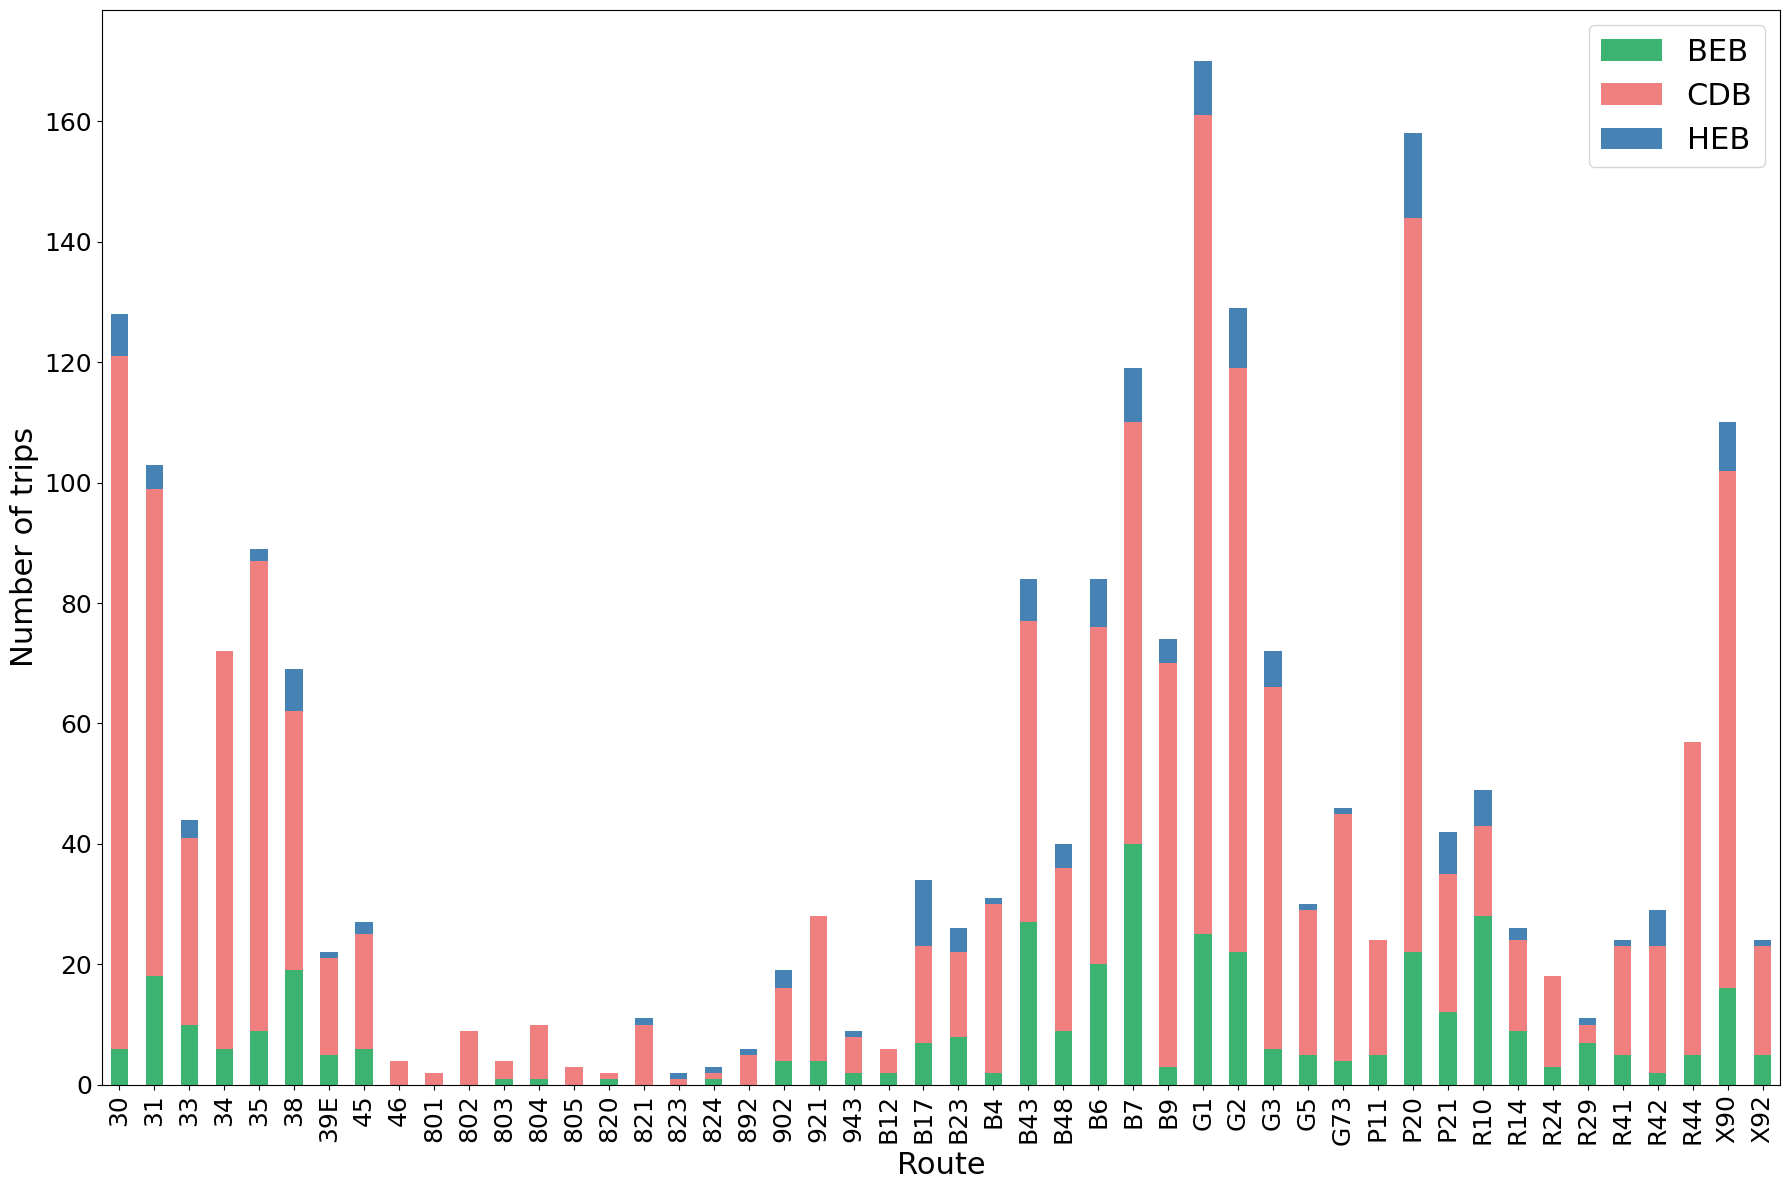

In [212]:
# Filter the dataframe for Year=13 and Value=1
l_BM_variables_filtered = l_BM_variables[(l_BM_variables['Year'] == 13) & (l_BM_variables['Value'] == 1)]
l_BM_variables_filtered = l_BM_variables_filtered[l_BM_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = l_BM_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(18, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=22)
ax.set_ylabel('Number of trips', fontsize=22)
ax.legend(fontsize=22)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()
plt.show()


In [213]:
l_BM_variables.to_csv(r'../../results/lowcap-BM-coefficients-integerated.csv', index=False)

In [214]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 17.96%


In [215]:
l_BM_variables_y = pd.read_csv(r'../../results/lowcap-BM-optimized-variables-y.csv', low_memory=False)

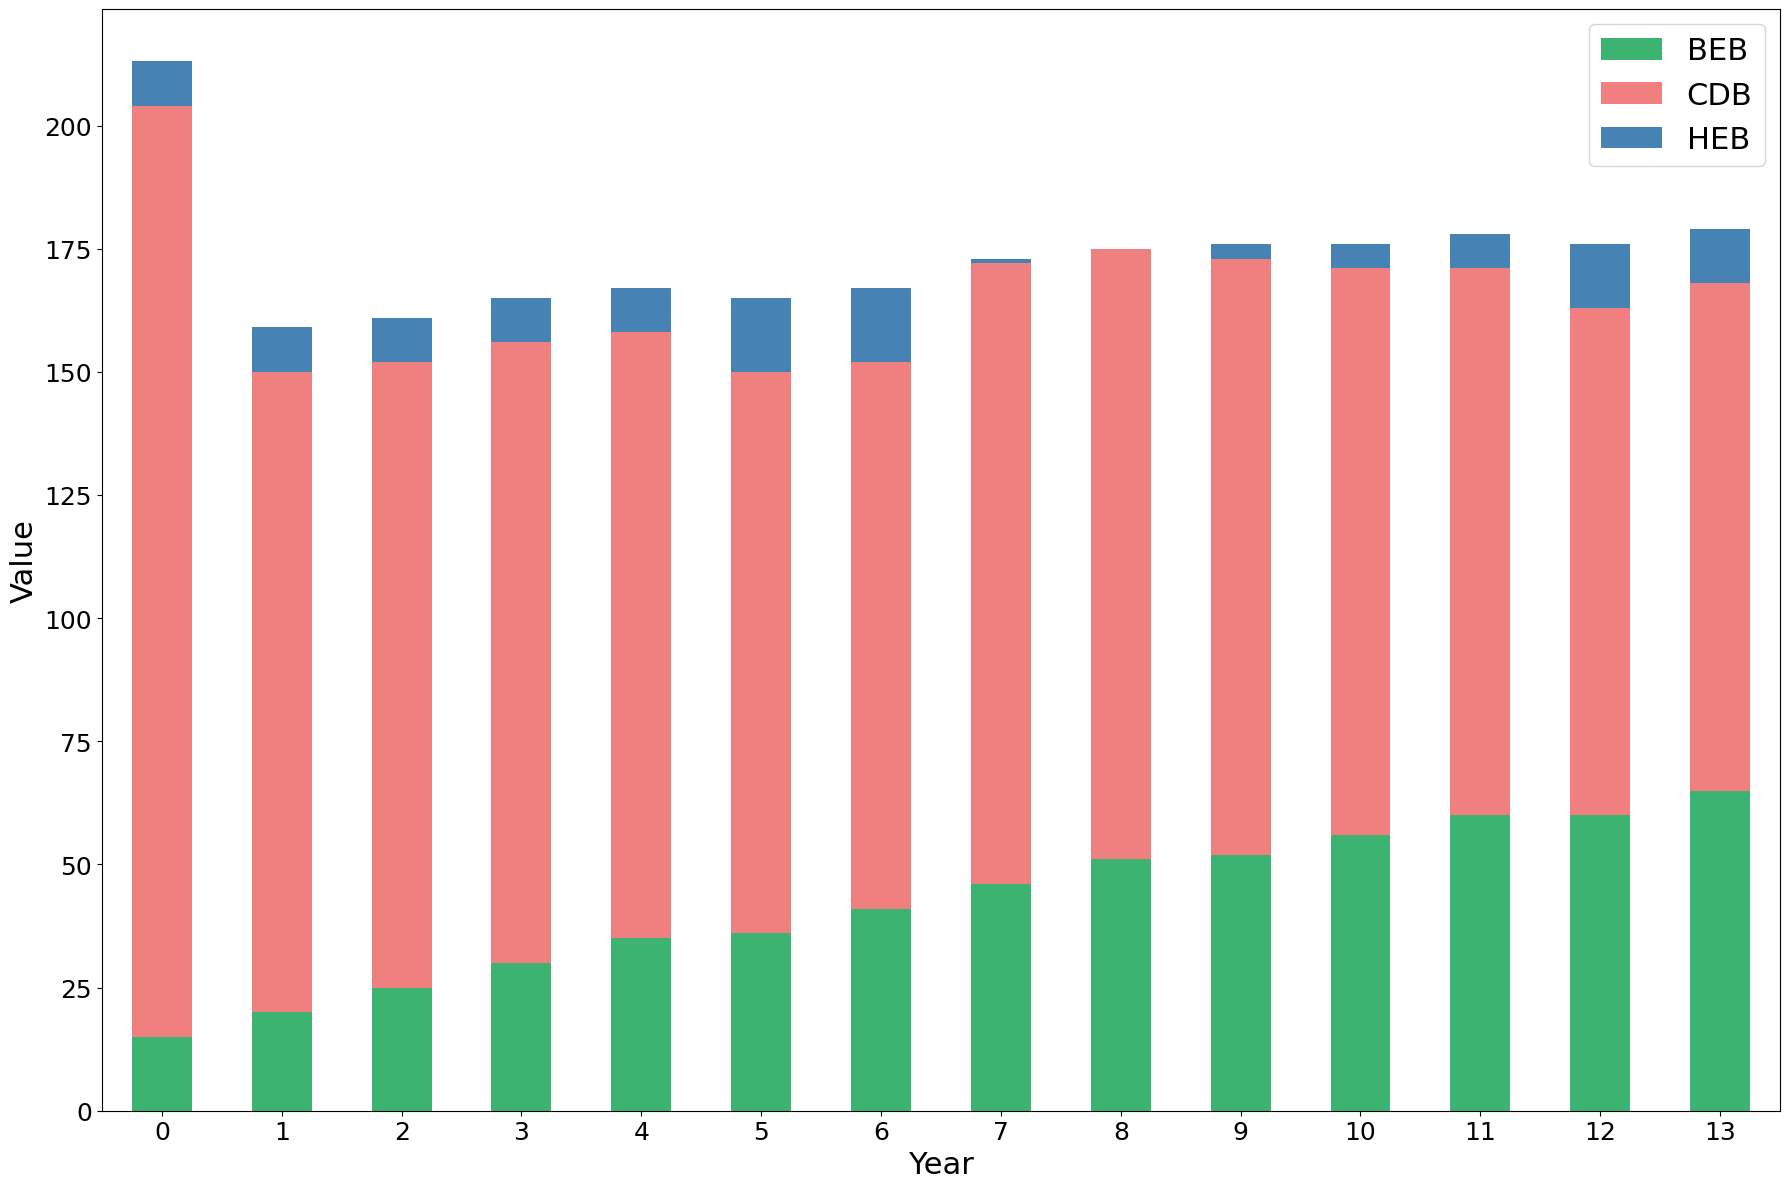

In [216]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = l_BM_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with a larger size
fig, ax = plt.subplots(figsize=(18, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate with BEB percentages
for index, (year, row) in enumerate(grouped_values.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    # Uncomment the next line if you want the BEB percentages to be displayed on the bars
    # ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=22)
ax.set_ylabel('Value', fontsize=22)
ax.legend(fontsize=22)
ax.set_xticklabels(grouped_values.index, rotation=0)


# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()
plt.show()


In [217]:
### BM High-cap Scenario

In [218]:
h_BM_variables = pd.read_csv(r'../../results/highcap-BM-optimized-variables.csv', low_memory=False)

In [286]:
h_BM_coefficients = pd.read_csv(r'../../results/highcap-BM-coefficients.csv', low_memory=False)

In [ ]:
data = {'Variable': ['x_CDB[low-cap,0,528277]'], 'Value': [1]}
h_BM_variables = pd.DataFrame(h_BM_variables)

# Extract attributes
h_BM_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = h_BM_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')

# Drop rows with nan values
h_BM_variables = h_BM_variables.dropna()

# Convert Year to numeric
h_BM_variables['Year'] = h_BM_variables['Year'].astype(int)

In [288]:
h_BM_coefficients = pd.DataFrame(h_BM_coefficients)

# Extract values using regex
h_BM_coefficients[['Scenario', 'Year', 'Trip']] = h_BM_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")

# Drop rows with NaN values (in case some rows don't match the pattern)
h_BM_coefficients = h_BM_coefficients.dropna()

# Convert 'Year' column to integer
h_BM_coefficients['Year'] = h_BM_coefficients['Year'].astype(int)

In [ ]:
h_BM_variables['Trip'] = h_BM_variables['Trip'].astype(str)
busiest_day['TripKey'] = busiest_day['TripKey'].astype(str)

# Merge the dataframes on matching values
merged_df = h_BM_variables.merge(h_BM_coefficients[['Scenario', 'Year', 'Trip', 'Coefficient']],
                                on=['Scenario', 'Year', 'Trip'],
                                how='left')


# Update h_BM_variables
h_BM_variables = merged_df

In [221]:
h_BM_variables['Trip'] = h_BM_variables['Trip'].astype(str)
busiest_day['TripKey'] = busiest_day['TripKey'].astype(str)

# Merge the dataframes on matching values
merged_df = h_BM_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update h_BM_variables
h_BM_variables = merged_df

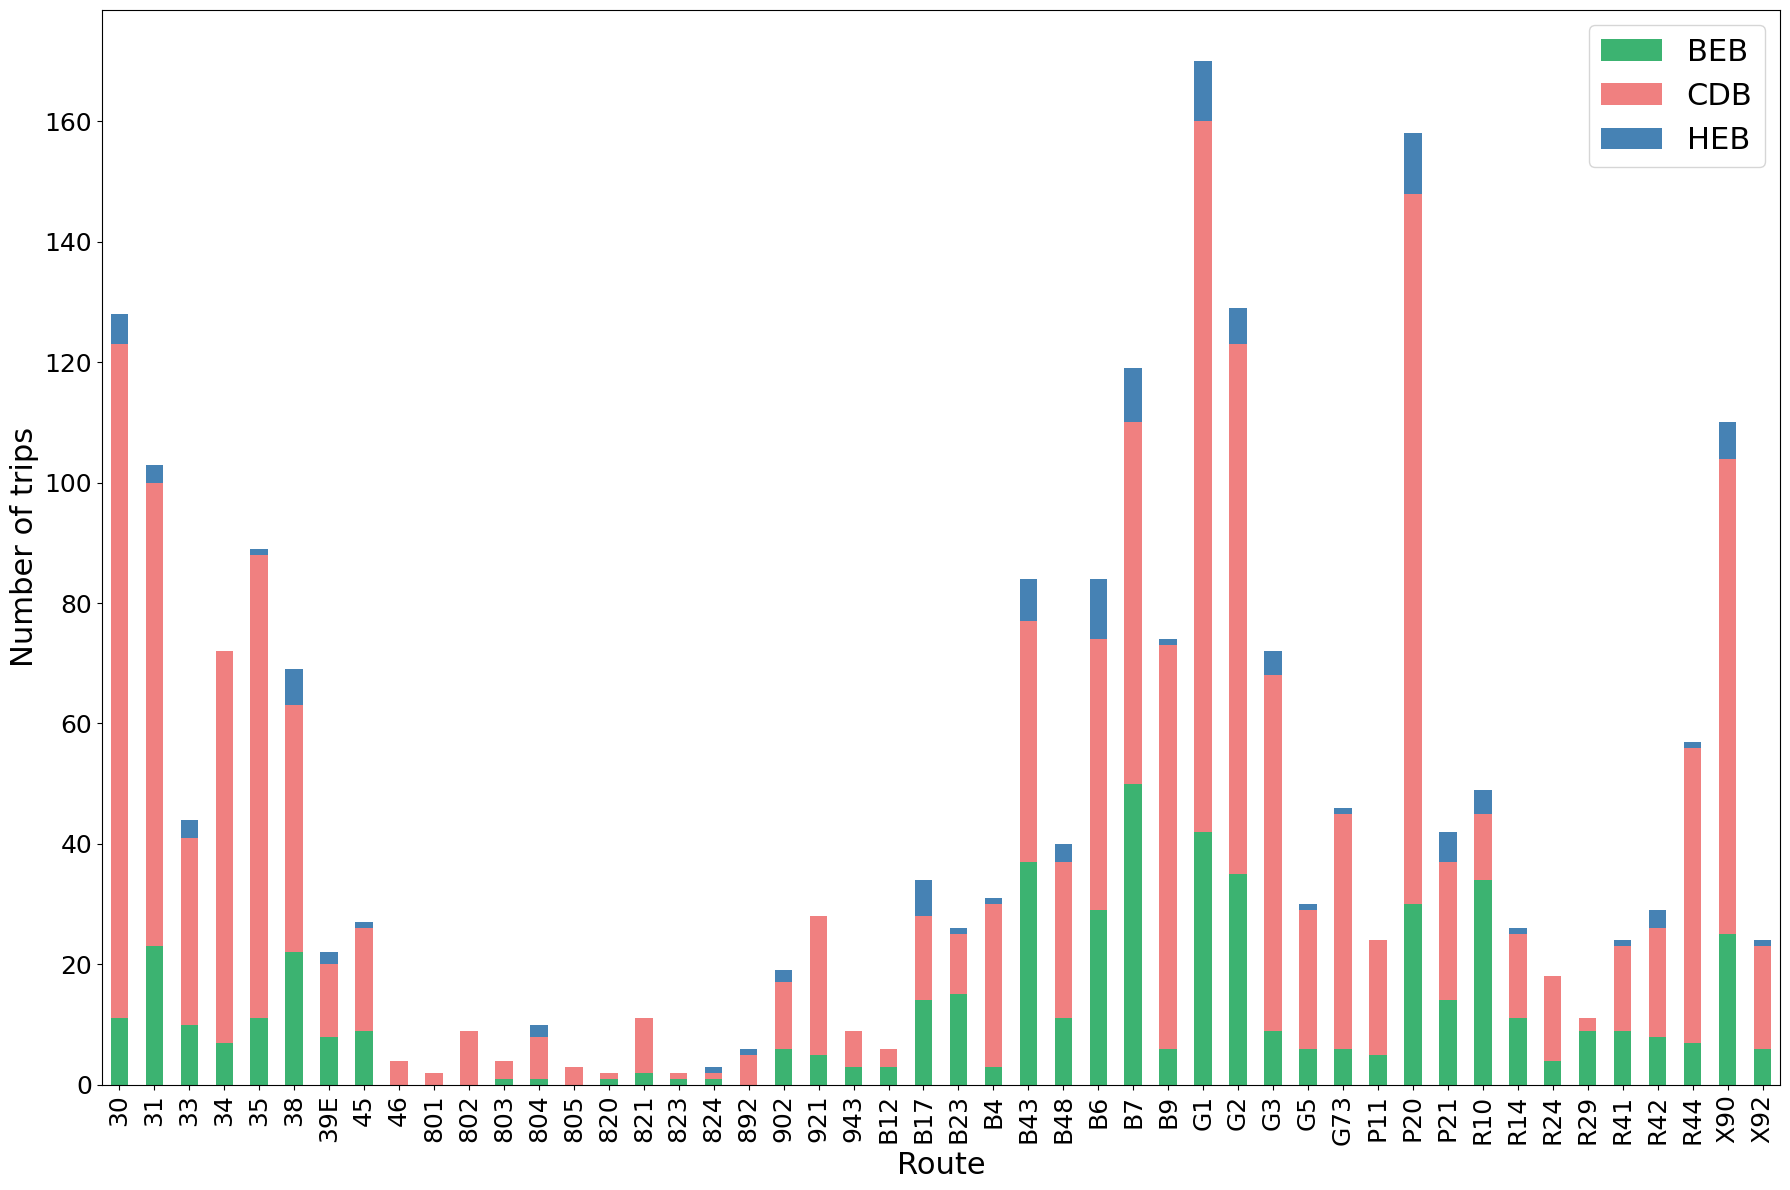

In [222]:
# Filter the dataframe for Year=13 and Value=1
h_BM_variables_filtered = h_BM_variables[(h_BM_variables['Year'] == 13) & (h_BM_variables['Value'] == 1)]
h_BM_variables_filtered = h_BM_variables_filtered[h_BM_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = h_BM_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(18, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=22)
ax.set_ylabel('Number of trips', fontsize=22)
ax.legend(fontsize=22)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()
plt.show()


In [227]:
h_BM_variables.to_csv(r'../../results/highcap-BM-optimized-variables-y.csv', index=False)

In [228]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 25.19%


In [229]:
h_BM_variables_y = pd.read_csv(r'../../results/highcap-BM-optimized-variables-y.csv', low_memory=False)

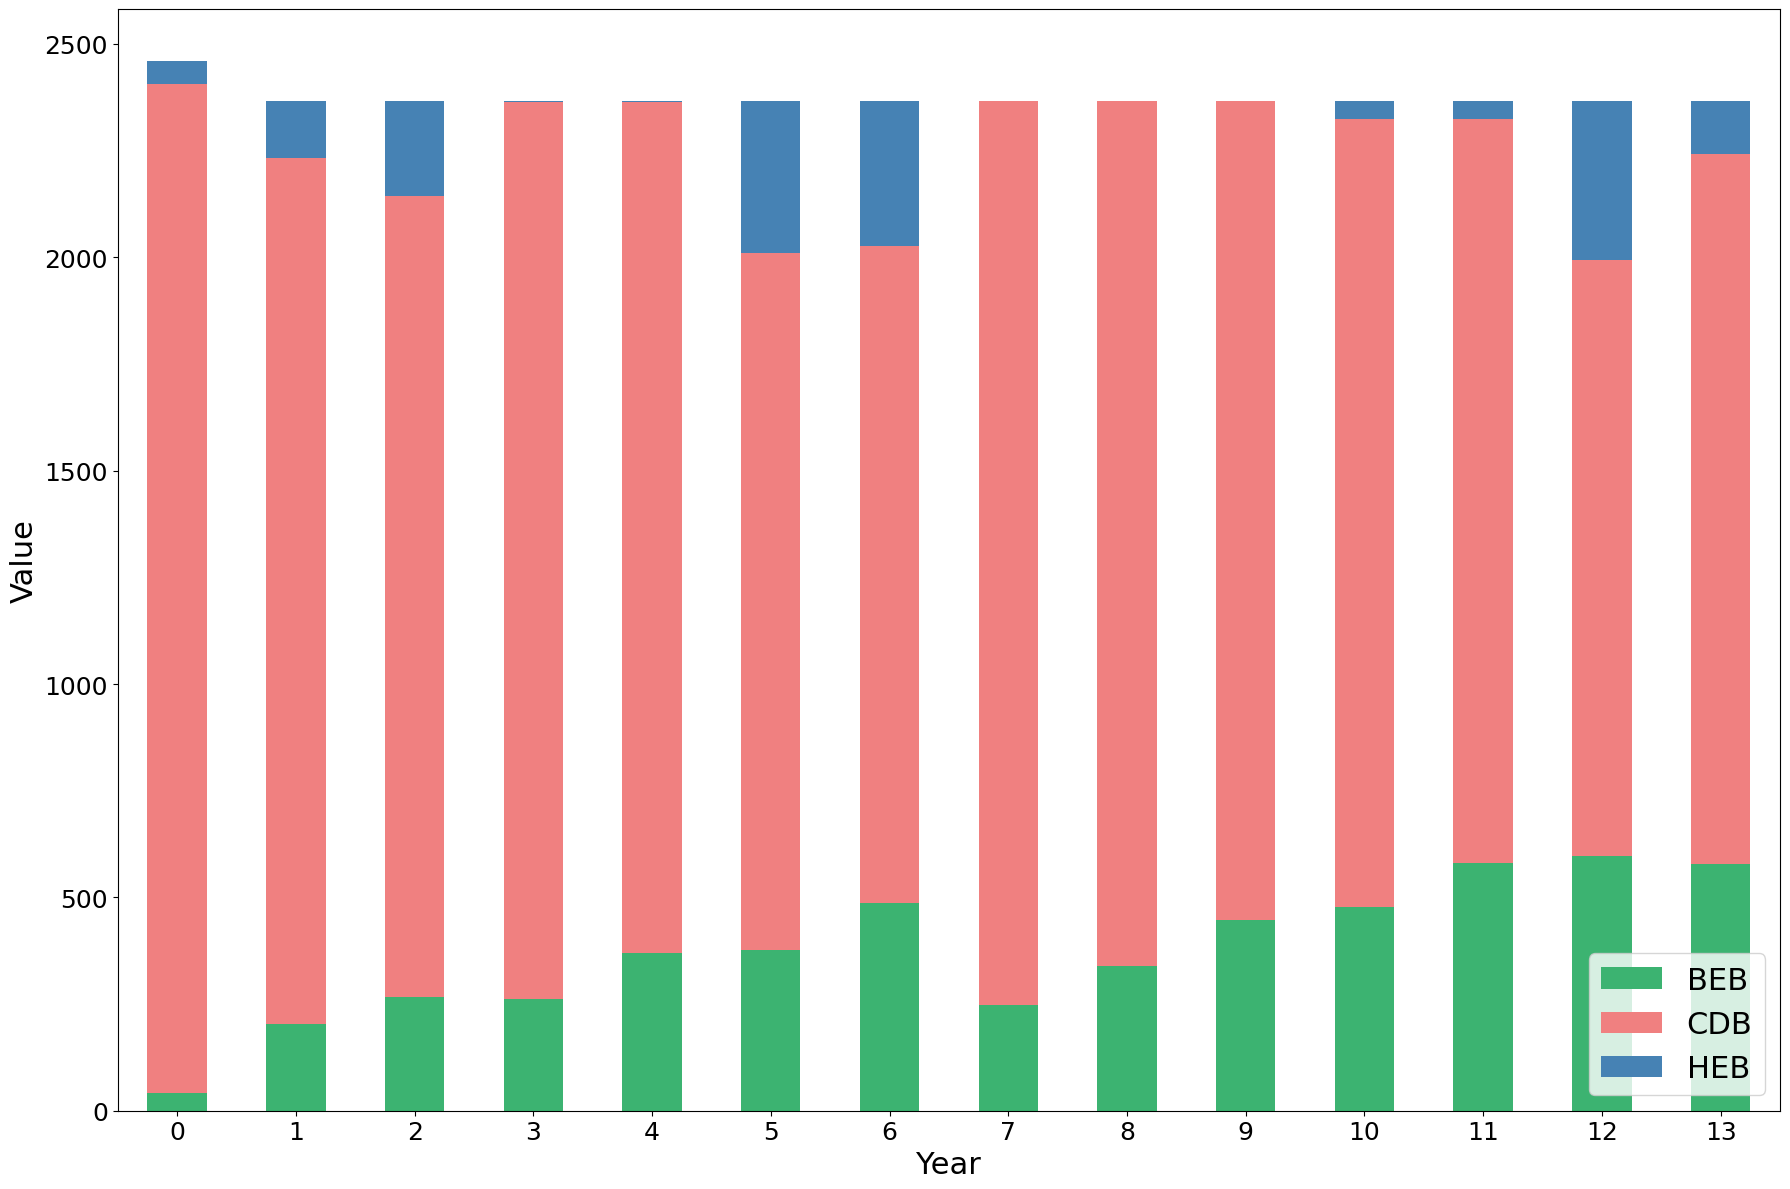

In [230]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = h_BM_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with a larger size
fig, ax = plt.subplots(figsize=(18, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate with BEB percentages
for index, (year, row) in enumerate(grouped_values.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    # Uncomment the next line if you want the BEB percentages to be displayed on the bars
    # ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=22)
ax.set_ylabel('Value', fontsize=22)
ax.legend(fontsize=22)
ax.set_xticklabels(grouped_values.index, rotation=0)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()
plt.show()


In [182]:
### BM Mid-cap Scenario

In [231]:
m_BM_variables = pd.read_csv(r'../../results/midcap-BM-optimized-variables.csv', low_memory=False)

In [287]:
m_BM_coefficients = pd.read_csv(r'../../results/midcap-BM-coefficients.csv', low_memory=False)

In [ ]:
data = {'Variable': ['x_CDB[low-cap,0,528277]'], 'Value': [1]}
m_BM_variables = pd.DataFrame(m_BM_variables)

# Extract attributes
m_BM_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = m_BM_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')

# Drop rows with nan values
m_BM_variables = m_BM_variables.dropna()

# Convert Year to numeric
m_BM_variables['Year'] = m_BM_variables['Year'].astype(int)

In [289]:
m_BM_coefficients = pd.DataFrame(m_BM_coefficients)

# Extract values using regex
m_BM_coefficients[['Scenario', 'Year', 'Trip']] = m_BM_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")

# Drop rows with NaN values (in case some rows don't match the pattern)
m_BM_coefficients = m_BM_coefficients.dropna()

# Convert 'Year' column to integer
m_BM_coefficients['Year'] = m_BM_coefficients['Year'].astype(int)

In [ ]:
m_BM_variables['Trip'] = m_BM_variables['Trip'].astype(str)
busiest_day['TripKey'] = busiest_day['TripKey'].astype(str)

# Merge the dataframes on matching values
merged_df = m_BM_variables.merge(m_BM_coefficients[['Scenario', 'Year', 'Trip', 'Coefficient']],
                                on=['Scenario', 'Year', 'Trip'],
                                how='left')


# Update h_BM_variables
m_BM_variables = merged_df

In [234]:
m_BM_variables['Trip'] = m_BM_variables['Trip'].astype(str)
busiest_day['TripKey'] = busiest_day['TripKey'].astype(str)

# Merge the dataframes on matching values
merged_df = m_BM_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update m_BM_variables
m_BM_variables = merged_df

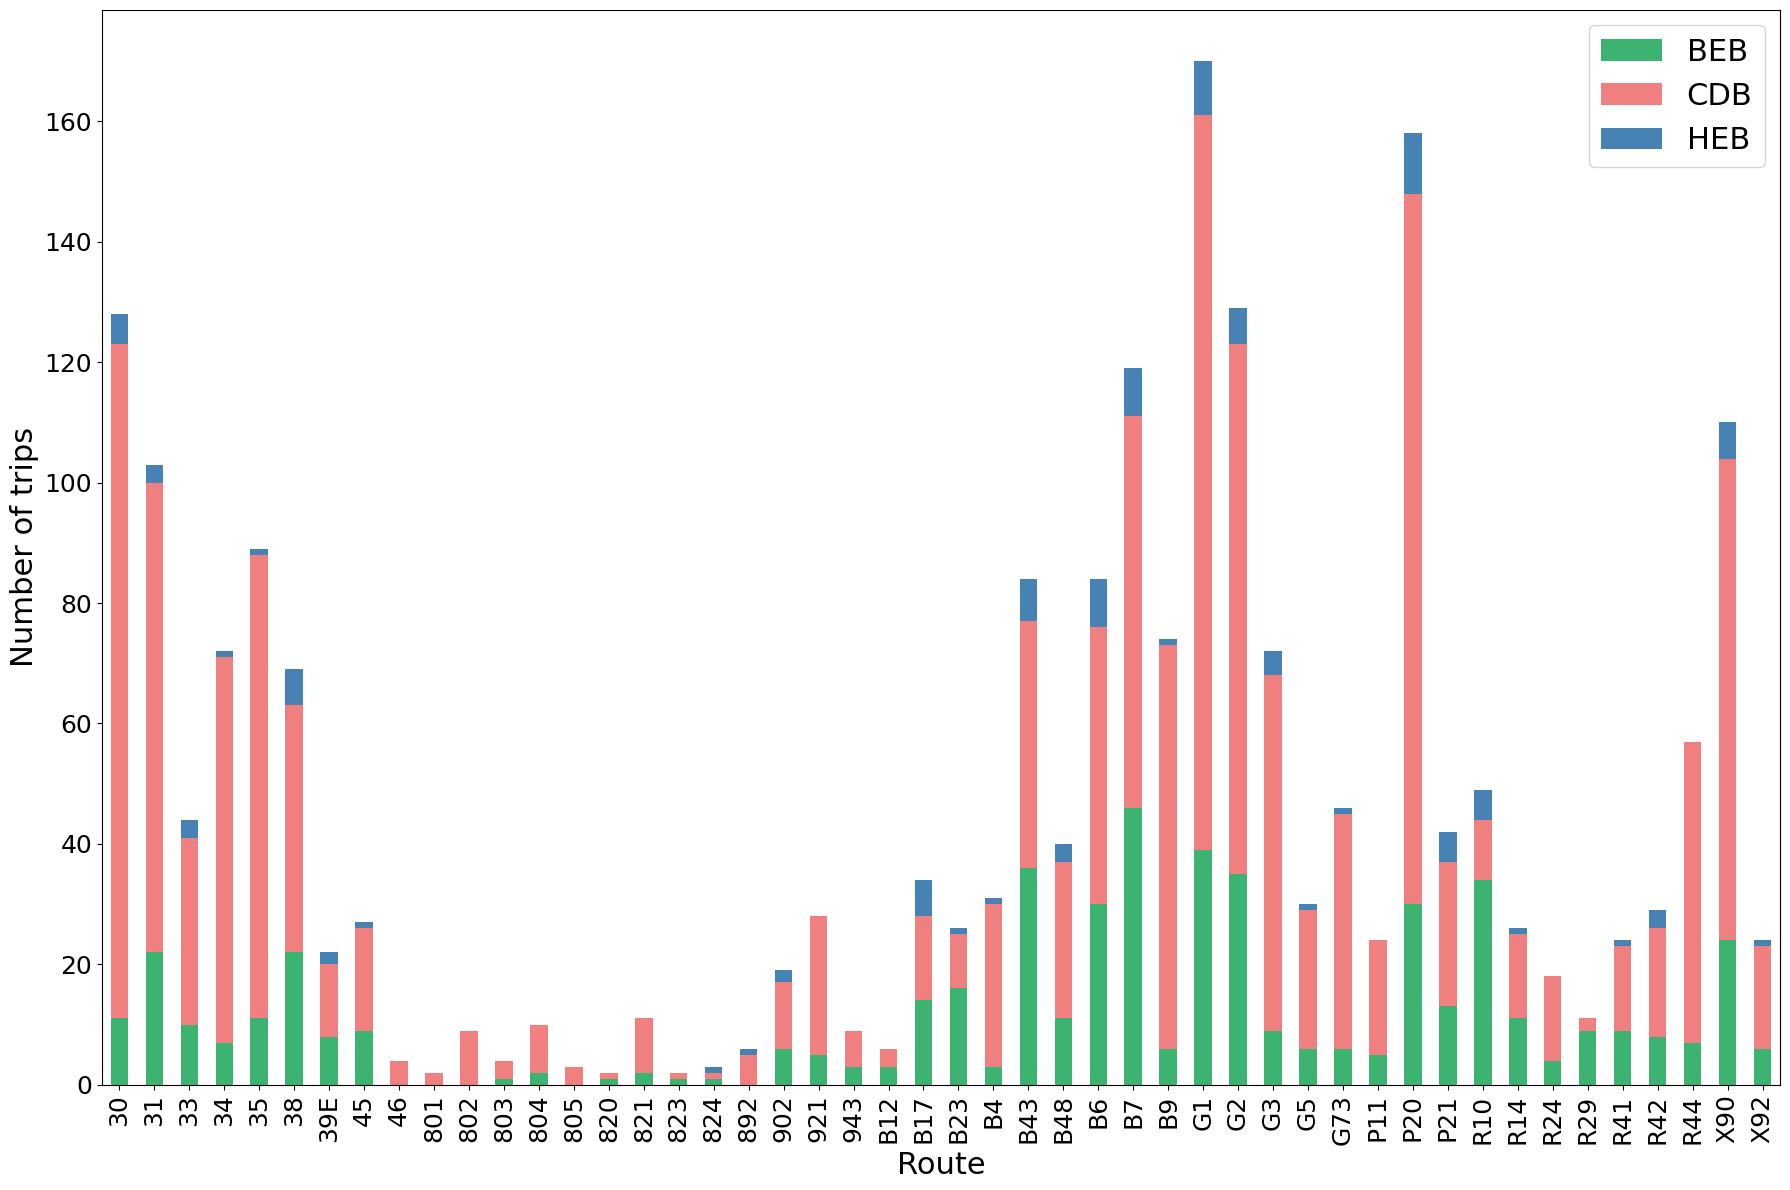

In [235]:
# Filter the dataframe for Year=13 and Value=1
m_BM_variables_filtered = m_BM_variables[(m_BM_variables['Year'] == 13) & (m_BM_variables['Value'] == 1)]
m_BM_variables_filtered = m_BM_variables_filtered[m_BM_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = m_BM_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(18, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=22)
ax.set_ylabel('Number of trips', fontsize=22)
ax.legend(fontsize=22)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()
plt.show()


In [236]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 24.83%


In [237]:
m_BM_variables_y = pd.read_csv(r'../../results/midcap-BM-optimized-variables-y.csv', low_memory=False)

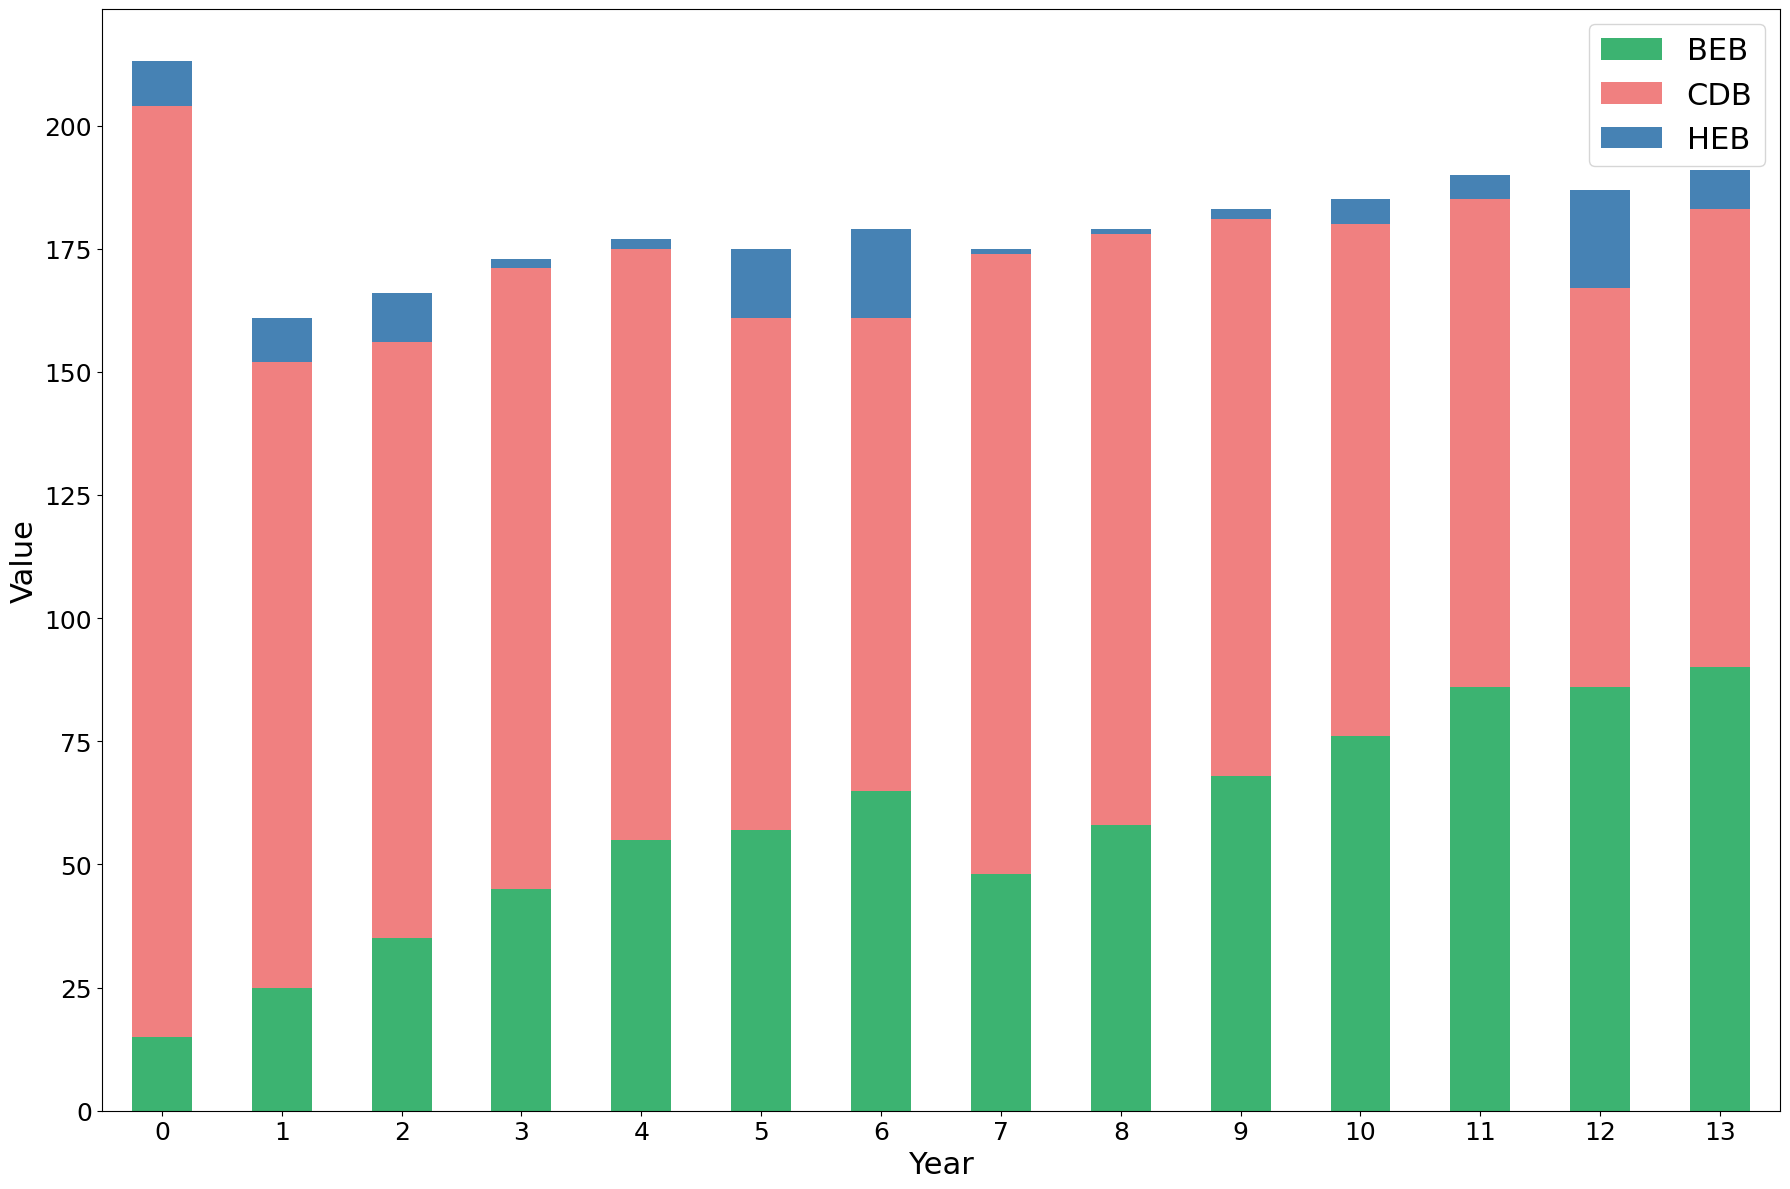

In [239]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = m_BM_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with a larger size
fig, ax = plt.subplots(figsize=(18, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate with BEB percentages
for index, (year, row) in enumerate(grouped_values.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    # Uncomment the next line if you want the BEB percentages to be displayed on the bars
    # ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=22)
ax.set_ylabel('Value', fontsize=22)
ax.legend(fontsize=22)
ax.set_xticklabels(grouped_values.index, rotation=0)


# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()
plt.show()


In [240]:
grouped_values

Powertrain,BEB,CDB,HEB
Year,,,
0,15,189,9
1,25,127,9
2,35,121,10
3,45,126,2
4,55,120,2
5,57,104,14
6,65,96,18
7,48,126,1
8,58,120,1
